# Histopathologic Cancer Detection

## Martin Ozaeta

https://github.com/MOzaeta96/Week-3-CNN-project.git

    For the Kaggle competition, we were tasked with identifying metastic cancer in small image patches from pathology scans.
This was accomplished via a deduplicated version of the PatchCamelyon or PCam dataset. For out initial work we needed to set everything up for our model:

### Importing Libraries:

    Our notebook thankfully has tensorflow, keras, opencv-python and matplotlib installed so we can move forward with importing the libraries we will be using:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from PIL import Image

In [2]:
# Restrict TensorFlow to a specific GPU
gpu_devices = tf.config.list_physical_devices('GPU')
if gpu_devices:
    try:
        # Set memory growth for each GPU to prevent memory allocation issues
        for gpu in gpu_devices:
            tf.config.experimental.set_memory_growth(gpu, True)
        
        # Set which GPU to use (optional)
        tf.config.set_visible_devices(gpu_devices[0], 'GPU')
    except RuntimeError as e:
        print(e)


    The libraries will allow us to manipulate data, process the images that are found in the data set, and create our model that will help with identifying the cancer cells.

### Loading Data:

In [3]:
def load_image(image_path, label):
    try:
        image = tf.io.read_file(image_path)
        image = tf.image.decode_image(image, channels=3, expand_animations=False)
        
        # Check if the image is valid
        if tf.reduce_any(tf.equal(tf.shape(image), 0)):
            raise ValueError(f"Image at path {image_path} is empty or could not be read.")
        
        image = tf.image.resize(image, [128, 128])
        image = tf.cast(image, tf.float32) / 255.0
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        image = tf.zeros([128, 128, 3])  # Create a dummy image if there's an error
    return image, label

def create_dataset_from_dataframe(df, base_path, batch_size=32):
    image_paths = df['id'].apply(lambda x: os.path.join(base_path, x)).values
    labels = df['label'].values
    
    image_paths = tf.convert_to_tensor(image_paths, dtype=tf.string)
    labels = tf.convert_to_tensor(labels, dtype=tf.int64)
    
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(lambda x, y: load_image(x, y), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset

# Load the training labels CSV
train_labels_df = pd.read_csv('C:\\Users\\marti\\Downloads\\histopathologic-cancer-detection\\train_labels.csv')

# Update the file extension and path if necessary
train_labels_df['id'] = train_labels_df['id'].apply(lambda x: x + '.tif')

# Split the data into training and validation sets
train_df, val_df = train_test_split(train_labels_df, test_size=0.2, stratify=train_labels_df['label'], random_state=42)

# Base path to the training images
train_base_path = 'C:\\Users\\marti\\Downloads\\histopathologic-cancer-detection\\train'

# Create TensorFlow datasets
batch_size = 32
train_dataset = create_dataset_from_dataframe(train_df, train_base_path, batch_size)
val_dataset = create_dataset_from_dataframe(val_df, train_base_path, batch_size)


Error loading image Tensor("args_0:0", shape=(), dtype=string): Image at path Tensor("args_0:0", shape=(), dtype=string) is empty or could not be read.
Error loading image Tensor("args_0:0", shape=(), dtype=string): Image at path Tensor("args_0:0", shape=(), dtype=string) is empty or could not be read.


### Exploratory Data Analysis

After loading the data we can do some preliminary analysis:

In [4]:
# First we can check for any missing values:
print(train_df.isnull().sum())
print(train_df.info())

# And get some basic information regarding the data:
print(train_df.describe())


id       0
label    0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 176020 entries, 198607 to 19034
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      176020 non-null  object
 1   label   176020 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 4.0+ MB
None
               label
count  176020.000000
mean        0.405034
std         0.490900
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000


With this all set we can now look into how the labels are being distributed:

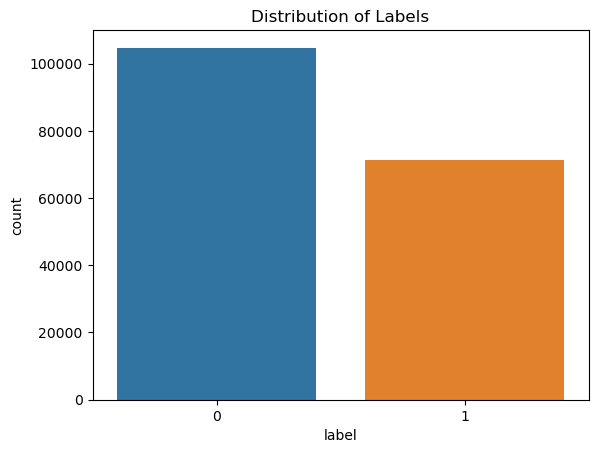

In [5]:
sns.countplot(x='label', data=train_df)
plt.title('Distribution of Labels')
plt.show()


We can also take some samples of images to get an idea of what we're dealing with:

File exists: C:\Users\marti\Downloads\histopathologic-cancer-detection\train\10628459a3db76efe0181d7bb2c3e5c22f46b063.tif
File exists: C:\Users\marti\Downloads\histopathologic-cancer-detection\train\981a2ad4e2e15f44c7fc655e85bbf23ce719cf71.tif
File exists: C:\Users\marti\Downloads\histopathologic-cancer-detection\train\07ef17af42e1e609e4d5c0348e879363cd62ca48.tif
File exists: C:\Users\marti\Downloads\histopathologic-cancer-detection\train\87f19964a29421fae8f2c44fa7a54b52985ac080.tif
File exists: C:\Users\marti\Downloads\histopathologic-cancer-detection\train\d65f64105fa86cc8ee9075a72c74d57683ce59ca.tif


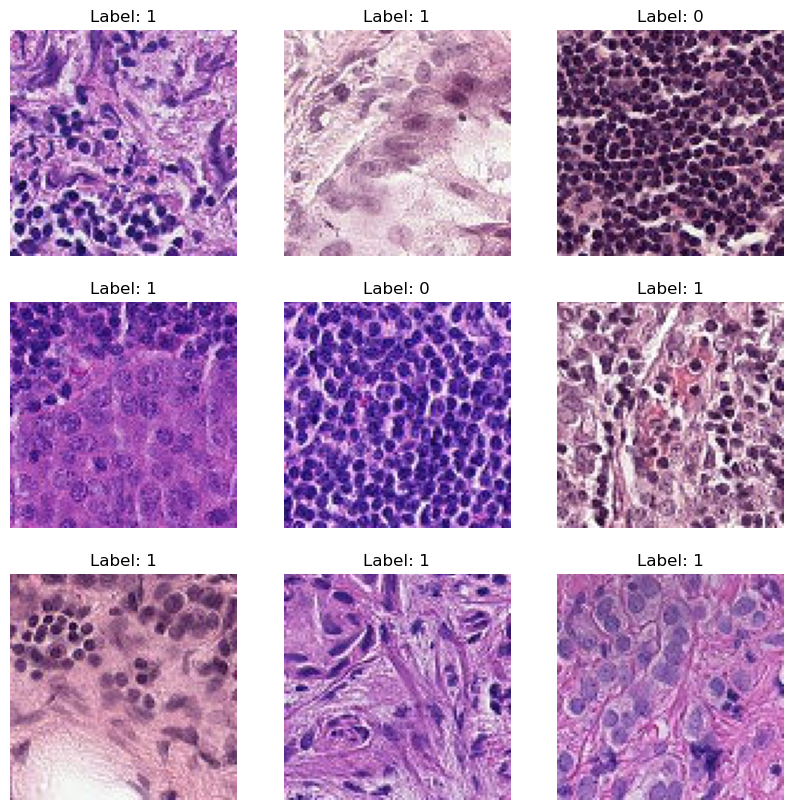

In [6]:
# Check if the constructed file paths exist
sample_images = train_df.sample(5)
for idx, row in sample_images.iterrows():
    img_path = os.path.join(train_base_path, row['id'])
    if os.path.exists(img_path):
        print(f"File exists: {img_path}")
    else:
        print(f"File does not exist: {img_path}")
def show_random_images(df, base_path, num_images=9):
    sample_images = df.sample(num_images)
    plt.figure(figsize=(10, 10))
    for i, (idx, row) in enumerate(sample_images.iterrows()):
        img_path = os.path.join(base_path, row['id'])
        if os.path.exists(img_path):
            img = Image.open(img_path)
            plt.subplot(3, 3, i+1)
            plt.imshow(img)
            plt.title(f"Label: {row['label']}")
            plt.axis('off')
        else:
            print(f"File not found: {img_path}")
    plt.show()

show_random_images(train_df, train_base_path)

We can also look into the distribution of pixels inthe images in our training data:

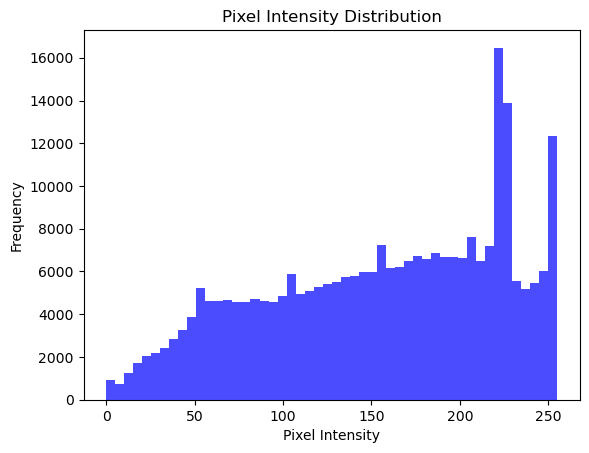

In [7]:
def plot_image_histogram(image_paths, base_path, num_images=10):
    pixel_values = []
    for img_path in image_paths.sample(num_images):
        full_path = os.path.join(base_path, img_path)
        img = Image.open(full_path)
        pixel_values.extend(np.array(img).flatten())
    plt.hist(pixel_values, bins=50, color='blue', alpha=0.7)
    plt.title('Pixel Intensity Distribution')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.show()

plot_image_histogram(train_df['id'], train_base_path)

### Creating the model and augmenting data:

In [8]:
# Define model creation function
def create_model(input_shape, num_classes):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=input_shape),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    return model

input_shape = (128, 128, 3)
num_classes = len(train_labels_df['label'].unique())  # Update with the number of classes

model = create_model(input_shape, num_classes)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


from tensorflow.keras.preprocessing.image import ImageDataGenerator

def create_augmentation_pipeline():
    return ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )


### Training and Testing the Data:

In [9]:
# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=5
)

Epoch 1/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 838s 152ms/step - accuracy: 0.5952 - loss: 0.6770 - val_accuracy: 0.5950 - val_loss: 0.6750
Epoch 2/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 802s 146ms/step - accuracy: 0.5952 - loss: 0.6750 - val_accuracy: 0.5950 - val_loss: 0.6750
Epoch 3/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 803s 146ms/step - accuracy: 0.5952 - loss: 0.6750 - val_accuracy: 0.5950 - val_loss: 0.6750
Epoch 4/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 818s 149ms/step - accuracy: 0.5952 - loss: 0.6750 - val_accuracy: 0.5950 - val_loss: 0.6750
Epoch 5/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 803s 146ms/step - accuracy: 0.5952 - loss: 0.6750 - val_accuracy: 0.5950 - val_loss: 0.6750


In [10]:
test_base_path = 'C:\\Users\\marti\\Downloads\\histopathologic-cancer-detection\\test' 

# List all files in the test directory
test_image_files = [f for f in os.listdir(test_base_path) if f.endswith('.tif')]

# Create DataFrame
test_df = pd.DataFrame({
    'id': test_image_files
})

# Optional: Add a placeholder label column if needed
test_df['label'] = -1

def create_test_dataset(df, base_path, batch_size=32):
    image_paths = df['id'].apply(lambda x: os.path.join(base_path, x)).values
    dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    dataset = dataset.map(lambda x: load_image(x, -1), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    return dataset

test_dataset = create_test_dataset(test_df, test_base_path, batch_size=32)


Error loading image Tensor("args_0:0", shape=(), dtype=string): Image at path Tensor("args_0:0", shape=(), dtype=string) is empty or could not be read.


### Create Predictions and prepare data for submission to Kaggle:

In [11]:
# Make predictions on the test dataset
predictions = model.predict(test_dataset)
predicted_classes = predictions.argmax(axis=-1)

# Add predictions to the DataFrame
test_df['label'] = predicted_classes

1796/1796 ━━━━━━━━━━━━━━━━━━━━ 48s 27ms/step


In [12]:
# Save submission file
test_df.to_csv('submission.csv', index=False)

# Compress into ZIP file
import zipfile

with zipfile.ZipFile('submission.zip', 'w') as zipf:
    zipf.write('submission.csv')